In [1]:
#importing some useful packages
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import glob


import time
#from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
import scipy.misc

%matplotlib inline

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    printed = False
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if not printed :
            print(np.amax(image), np.amin(image))
            img = image
            print("In extract", type(img), img.shape, type(img[0][0][0]), type(img[0][0]), img[0][0])
            print("feature ", type(feature_image), feature_image.shape, feature_image[0][0])
            print("feature moin max", np.amin(feature_image), np.amax(feature_image))
            printed = True
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 

    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense

    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):   
    img = img.astype(np.float32) / 255. 
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    count = 0
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0, 255), 12)
    # Return the image
    return img

def load_image_names(folder) :
    return glob.glob(folder + '/*.png')

def saveImg(folder, image, idx) :
    scipy.misc.imsave('video_images/' + folder + '/video' + str(idx) + '.jpg', image) 

def smooth(heatmap) :
    min = np.min(heatmap)
    max = np.max(heatmap)
    
    if min != max :
        heatmap[heatmap == min] = 0
    return heatmap
    
neighborNum = 6
boxes = []
idx = 0
threshold = neighborNum - 1

def handleImage(image) :
    global idx
    global neighborNum
    global boxes
    global threshold
    global windows
    
    draw_image = np.copy(image)
    
    box_list = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    boxes.append(box_list)
    if len(boxes) > neighborNum :
        boxes.pop(0)

    # Add heat to each box in box list
    for box in boxes :
        heat = add_heat(heat, box)
        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, min(threshold, idx))
    
    heat = smooth(heat)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    idx = idx + 1
    return box_list, draw_img

def detectImage(image) :
    box_list, draw_img = handleImage(image)
    return draw_img

In [3]:
folders = ["KITTI_extracted", "GTI_Far", "GTI_Left", "GTI_MiddleClose", "GTI_Right"]

cars = []
for folder in folders :
    cars = cars + load_image_names('training_images/vehicles/' + folder)

folders = ['GTI', 'Extras']
notcars = []
for folder in folders :
    notcars = notcars + load_image_names('training_images/non-vehicles/' + folder)

print(len(cars), len(notcars))

random.shuffle(cars)
random.shuffle(notcars)

print("loaded")

8792 8968
loaded


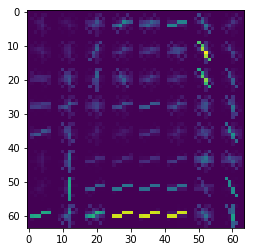

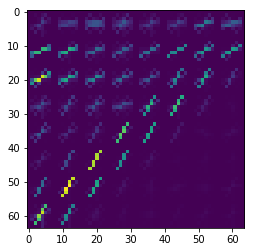

In [16]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

#random_idx = np.random.randint(0, 100)
image = mpimg.imread('training_images/vehicles/GTI_Far/image0005.png')
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
features, hogImg = get_hog_features(feature_image[:,:,0], orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, vis=True, feature_vec=True)
plt.figure()
plt.imshow(hogImg)

image1 = mpimg.imread('training_images/non-vehicles/GTI/image13.png')
feature_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2YCrCb)
features1, hogImg1 = get_hog_features(feature_image1[:,:,0], orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, vis=True, feature_vec=True)
plt.figure()
plt.imshow(hogImg1)

In [10]:
print("Starting calculating model")

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = False # Spatial features on or off

hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(car_features[0].shape)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#print(notcar_features[0].shape)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# the best parameter through testing
clf = MLPClassifier()
t=time.time()
print("start training")
clf.fit(X_train, y_train)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to train MLPClassifier...')
# Check the score of the SVC
print('Test Accuracy of MLPClassifier = ', round(clf.score(X_test, y_test), 4))

print("Done")

Starting calculating model
1.0 0.0156863
In extract <class 'numpy.ndarray'> (64, 64, 3) <class 'numpy.float32'> <class 'numpy.ndarray'> [ 0.29411766  0.28627452  0.25098041]
feature  <class 'numpy.ndarray'> (64, 64, 3) [ 0.28459612  0.50678885  0.48104075]
feature moin max 0.0221216 1.0
(10800,)
0.862745 0.0
In extract <class 'numpy.ndarray'> (64, 64, 3) <class 'numpy.float32'> <class 'numpy.ndarray'> [ 0.20784314  0.16862746  0.10588235]
feature  <class 'numpy.ndarray'> (64, 64, 3) [ 0.17320001  0.52470052  0.46203285]
feature moin max 0.0 0.759643
Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 10800
start training
160.14 Seconds to train MLPClassifier...
Test Accuracy of MLPClassifier =  0.9927
Done


In [5]:
x_start_stop=[None, None]
size_ranges = (64, 96, 128, 192)
y_end_rates = (0.8, 0.8, 1, 1)
overlaps = (0.8, 0.8, 0.8, 0.8)

sample_image = mpimg.imread('test_images/test4.jpg')

windows = []
for y_end, xysize, overlap in zip(y_end_rates, size_ranges, overlaps) :
    size = (xysize, xysize)

    y_start_stop = [400, int(y_end * sample_image.shape[0])]
    windows.extend(slide_window(sample_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=size, xy_overlap=(overlap, overlap))) 

print("Window size", len(windows))

Window size 1827


In [7]:
from moviepy.editor import *

idx = 0
boxes = []
project_output = 'output_images/project_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
#clip1 = VideoFileClip("project_video.mp4").subclip(26,29)
#project_clip = clip1.fl_image(detectImage) #NOTE: this function expects color images!!

#project_clip = clip1.fl_image(testImg) #NOTE: this function expects color images!!
#%time project_clip.write_videofile(project_output, audio=False)

(720, 1280, 3)
[119 154 190]
[((1068, 400), (1132, 464)), ((1044, 412), (1108, 476)), ((1056, 424), (1120, 488)), ((969, 400), (1065, 496)), ((1026, 400), (1122, 496)), ((1045, 400), (1141, 496)), ((1064, 400), (1160, 496)), ((1121, 400), (1217, 496)), ((1140, 400), (1236, 496)), ((1159, 400), (1255, 496)), ((1026, 419), (1122, 515)), ((1045, 419), (1141, 515)), ((1102, 419), (1198, 515)), ((1121, 419), (1217, 515)), ((1178, 419), (1274, 515)), ((1025, 400), (1153, 528)), ((1050, 400), (1178, 528)), ((1075, 400), (1203, 528)), ((1150, 400), (1278, 528))]


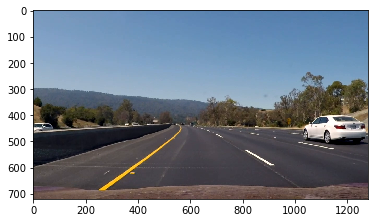

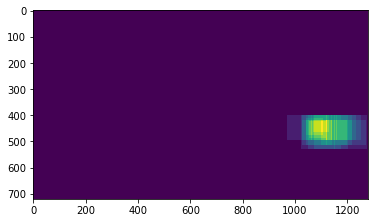

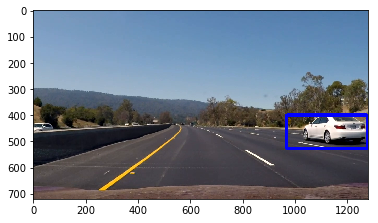

(720, 1280, 3)
[124 156 193]
[((1056, 424), (1120, 488)), ((988, 400), (1084, 496)), ((1007, 400), (1103, 496)), ((1026, 400), (1122, 496)), ((1064, 400), (1160, 496)), ((1083, 400), (1179, 496)), ((1102, 400), (1198, 496)), ((988, 419), (1084, 515)), ((1007, 419), (1103, 515)), ((1026, 419), (1122, 515)), ((1045, 419), (1141, 515)), ((1102, 419), (1198, 515)), ((1140, 419), (1236, 515)), ((975, 400), (1103, 528)), ((1000, 400), (1128, 528)), ((1075, 400), (1203, 528)), ((1100, 400), (1228, 528)), ((1100, 425), (1228, 553))]


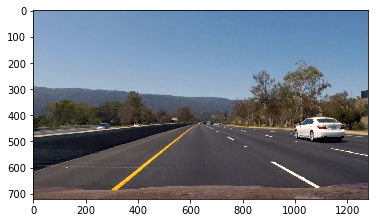

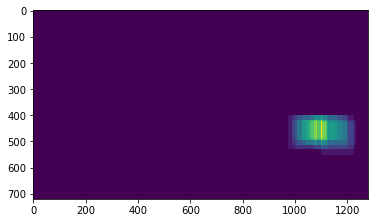

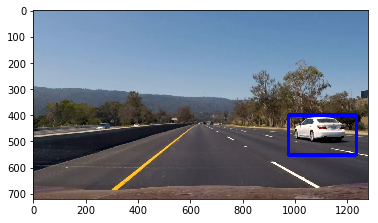

(720, 1280, 3)
[128 160 197]
[((936, 412), (1000, 476)), ((948, 412), (1012, 476)), ((960, 412), (1024, 476)), ((931, 400), (1027, 496)), ((950, 400), (1046, 496)), ((969, 400), (1065, 496)), ((988, 400), (1084, 496)), ((1007, 419), (1103, 515)), ((975, 400), (1103, 528))]


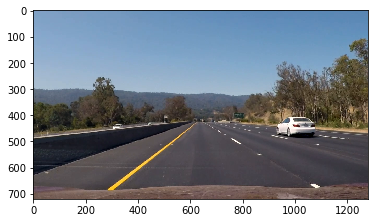

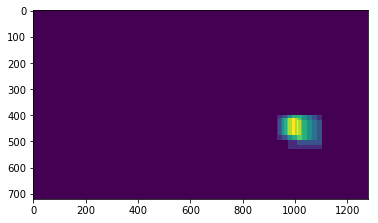

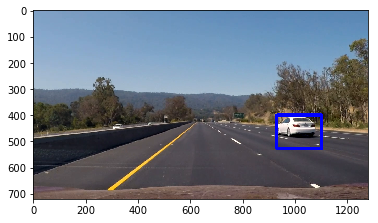

(720, 1280, 3)
[128 160 197]
[((900, 400), (964, 464)), ((912, 400), (976, 464)), ((924, 400), (988, 464)), ((948, 400), (1012, 464)), ((888, 412), (952, 476)), ((900, 412), (964, 476)), ((912, 412), (976, 476)), ((893, 400), (989, 496)), ((912, 400), (1008, 496)), ((931, 400), (1027, 496)), ((950, 400), (1046, 496)), ((875, 400), (1003, 528)), ((900, 400), (1028, 528))]


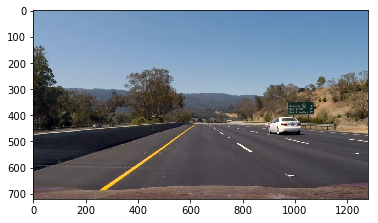

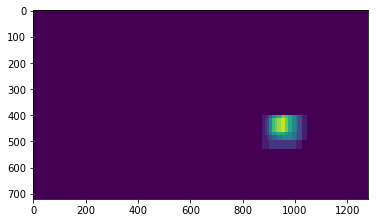

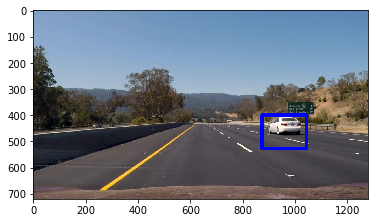

(720, 1280, 3)
[121 158 196]
[((888, 400), (952, 464)), ((900, 400), (964, 464)), ((912, 400), (976, 464)), ((924, 400), (988, 464)), ((912, 412), (976, 476)), ((936, 412), (1000, 476)), ((948, 412), (1012, 476)), ((855, 400), (951, 496)), ((874, 400), (970, 496)), ((893, 400), (989, 496)), ((912, 400), (1008, 496)), ((931, 400), (1027, 496)), ((893, 419), (989, 515)), ((912, 419), (1008, 515)), ((875, 400), (1003, 528))]


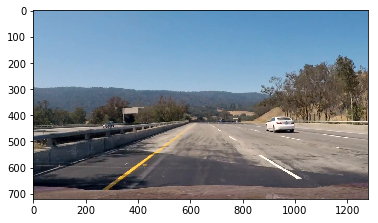

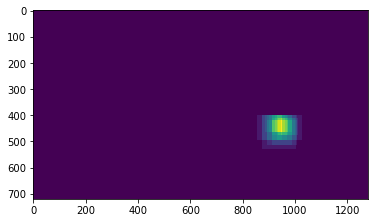

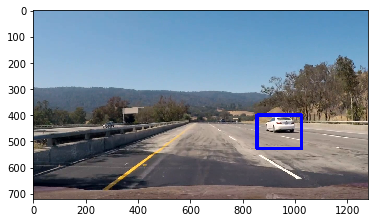

(720, 1280, 3)
[ 98 138 179]
[((912, 412), (976, 476)), ((924, 412), (988, 476)), ((855, 400), (951, 496)), ((893, 400), (989, 496)), ((912, 419), (1008, 515))]


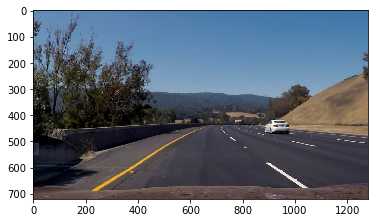

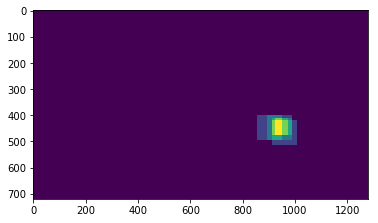

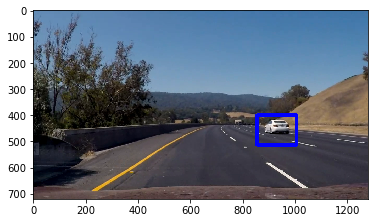

(720, 1280, 3)
[116 156 195]
[((876, 412), (940, 476)), ((836, 400), (932, 496)), ((855, 400), (951, 496)), ((1159, 438), (1255, 534)), ((1150, 425), (1278, 553))]


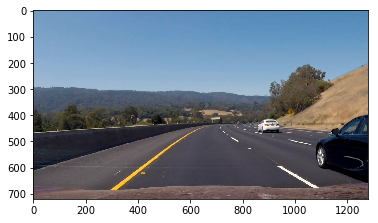

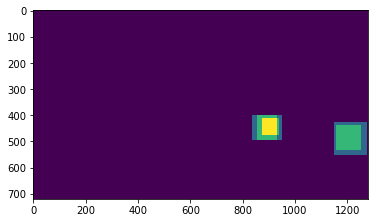

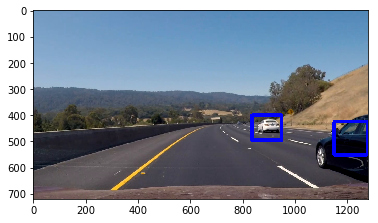

(720, 1280, 3)
[116 157 194]
[((888, 400), (952, 464)), ((900, 400), (964, 464)), ((876, 412), (940, 476)), ((888, 412), (952, 476)), ((996, 484), (1060, 548)), ((1008, 484), (1072, 548)), ((1032, 484), (1096, 548)), ((1044, 484), (1108, 548)), ((855, 400), (951, 496)), ((1064, 400), (1160, 496)), ((931, 419), (1027, 515)), ((969, 419), (1065, 515)), ((988, 419), (1084, 515)), ((1045, 419), (1141, 515)), ((931, 438), (1027, 534)), ((988, 438), (1084, 534)), ((1064, 438), (1160, 534)), ((1083, 438), (1179, 534)), ((1007, 457), (1103, 553)), ((1026, 457), (1122, 553)), ((1064, 457), (1160, 553)), ((1083, 457), (1179, 553)), ((988, 476), (1084, 572)), ((1026, 476), (1122, 572)), ((925, 400), (1053, 528)), ((950, 400), (1078, 528)), ((1025, 400), (1153, 528)), ((925, 425), (1053, 553)), ((975, 425), (1103, 553)), ((1050, 425), (1178, 553)), ((1075, 425), (1203, 553)), ((1050, 450), (1178, 578)), ((950, 400), (1142, 592)), ((988, 400), (1180, 592))]


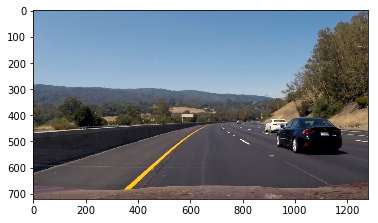

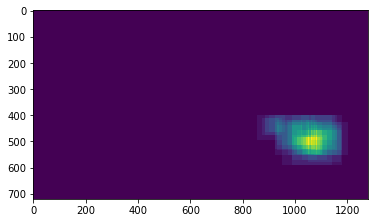

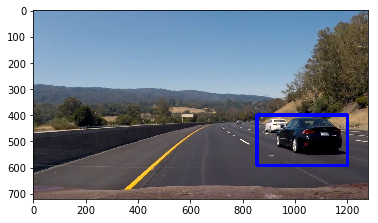

(720, 1280, 3)
[114 151 189]
[((876, 436), (940, 500)), ((888, 448), (952, 512)), ((855, 400), (951, 496)), ((912, 400), (1008, 496)), ((931, 400), (1027, 496)), ((855, 419), (951, 515)), ((874, 419), (970, 515)), ((893, 419), (989, 515)), ((912, 419), (1008, 515)), ((931, 419), (1027, 515)), ((874, 438), (970, 534)), ((893, 438), (989, 534)), ((912, 438), (1008, 534)), ((931, 438), (1027, 534)), ((825, 400), (953, 528)), ((850, 400), (978, 528)), ((875, 400), (1003, 528)), ((900, 400), (1028, 528)), ((925, 400), (1053, 528)), ((875, 425), (1003, 553)), ((900, 425), (1028, 553))]


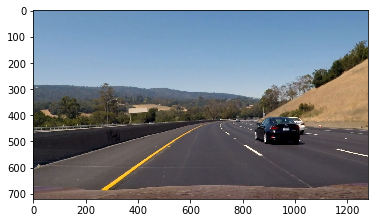

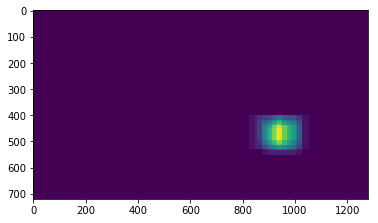

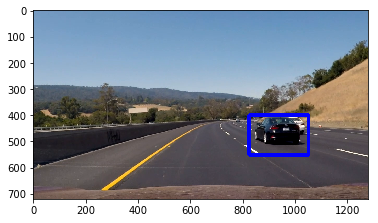

(720, 1280, 3)
[107 148 191]
[((876, 412), (940, 476)), ((972, 412), (1036, 476)), ((984, 412), (1048, 476)), ((1008, 412), (1072, 476)), ((1020, 412), (1084, 476)), ((864, 424), (928, 488)), ((1008, 424), (1072, 488)), ((1056, 424), (1120, 488)), ((888, 448), (952, 512)), ((798, 400), (894, 496)), ((817, 400), (913, 496)), ((836, 400), (932, 496)), ((855, 400), (951, 496)), ((950, 400), (1046, 496)), ((969, 400), (1065, 496)), ((988, 400), (1084, 496)), ((1007, 400), (1103, 496)), ((1026, 400), (1122, 496)), ((1045, 400), (1141, 496)), ((817, 419), (913, 515)), ((836, 419), (932, 515)), ((855, 419), (951, 515)), ((1045, 419), (1141, 515)), ((836, 438), (932, 534)), ((855, 438), (951, 534)), ((775, 400), (903, 528)), ((800, 400), (928, 528)), ((825, 400), (953, 528)), ((850, 400), (978, 528)), ((825, 425), (953, 553))]


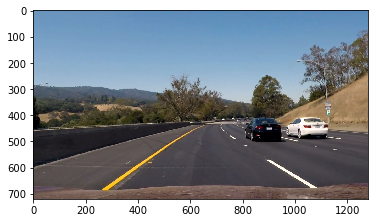

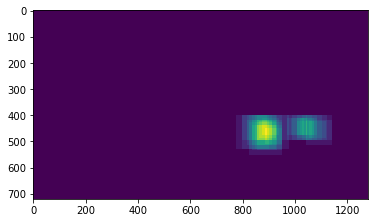

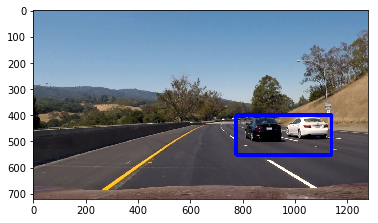

In [29]:
idx = 0
boxes = []
for i in range(10, 40, 3):
    frame1 = clip1.get_frame(i)
    print(frame1.shape)
    print(frame1[0][0])
    box_list, outImg = handleImage(frame1)
    print(box_list)
    heat = np.zeros_like(frame1[:,:,0]).astype(np.float32)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)

    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame1), labels)
    plt.figure()
    plt.imshow(frame1)
    saveImg('origimg', frame1, i)
    plt.figure()
    plt.imshow(heatmap)
    saveImg('heatimg', heatmap, i)
    plt.figure()
    plt.imshow(draw_img)
    saveImg('retimg', draw_img, i)
    plt.show()